In [ ]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import sklearn.metrics
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# Load the trained model

In [ ]:
main_model = load_model('/content/drive/MyDrive/Colab_Notebooks/covid_19/covid_trained_model.h5')


In [ ]:
# prepare test batches
test_path = '/content/drive/MyDrive/Colab_Notebooks/covid_19/data_set/four_classes/test'
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_batches = test_datagen.flow_from_directory(test_path, target_size=(150,150), batch_size=1, shuffle=False, seed=42, class_mode="categorical")

# predict the test file and compare the result of all images with file names(real label)
count=[0,0,0,0]
files = test_batches.filenames
for i in range(len(files)):
  x,y = next(test_batches)
  predict = main_model.predict(x)
  p=np.argmax(predict, axis=-1)
  print(str(p[0])+" "+files[test_batches.batch_index-1])
  count[p[0]]+=1

print(count)

Found 242 images belonging to 4 classes.
1/1 [==============================] - 1s 1s/step
0 covid/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg
1/1 [==============================] - 0s 119ms/step
0 covid/SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day12.jpeg
1/1 [==============================] - 0s 132ms/step
0 covid/X-ray_of_cyst_in_pneumocystis_pneumonia_1.jpg
1/1 [==============================] - 0s 122ms/step
0 covid/covid-19-pneumonia-41.jpg
1/1 [==============================] - 0s 123ms/step
0 covid/covid-19-pneumonia-58-day-10.jpg
1/1 [==============================] - 0s 118ms/step
0 covid/covid-19-pneumonia-67.jpeg
1/1 [==============================] - 0s 117ms/step
0 covid/covid-19-pneumonia-evolution-over-a-week-1-day6.jpg
1/1 [==============================] - 0s 123ms/step
0 covid/covid-19-pneumonia-rapidly-progressive-3-days.jpg
1/1 [==============================] - 0s 199ms/step
0 covid/covid-19-rapidly-progressive-acute-respiratory-distress-syndrome-ards-day-

# Confusion Matrix

In [ ]:
# define a function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# predict the test batches again to plot confusion matrix
predict_2 = main_model.predict_generator(test_batches,
                           steps = np.ceil(len(test_batches)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,)


<ipython-input-29-5e3458ff3a58>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict_2 = main_model.predict_generator(test_batches,


242/242 [==============================] - 35s 142ms/step


Confusion matrix, without normalization
[[20  0  0  0]
 [12 56  2  7]
 [ 0  1 65  9]
 [ 1  1 10 58]]
0.8223140495867769


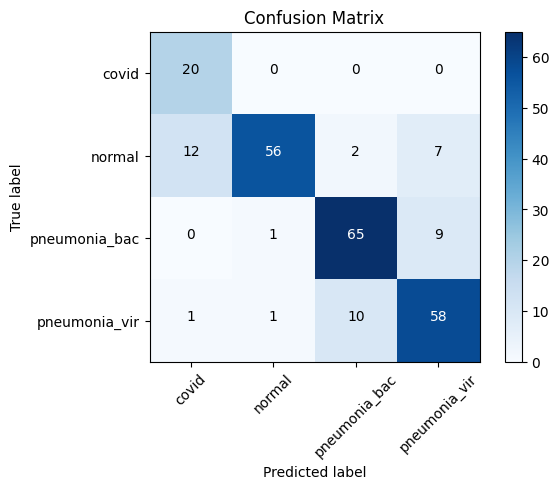

In [ ]:
# choose a class which has the max prediction value
predictions = np.argmax(predict_2, axis=-1)
classes = test_batches.classes[test_batches.index_array] # get the classes to pass the CM
cm = confusion_matrix(classes, predictions)
names=["covid","normal","pneumonia_bac","pneumonia_vir"]

plot_confusion_matrix(cm=cm, classes=names, title='Confusion Matrix')
acc=sum(predictions==classes)/len(predictions) # calculate the accuracy
print(acc)

# Test a single image

1/1 [==============================] - 0s 120ms/step


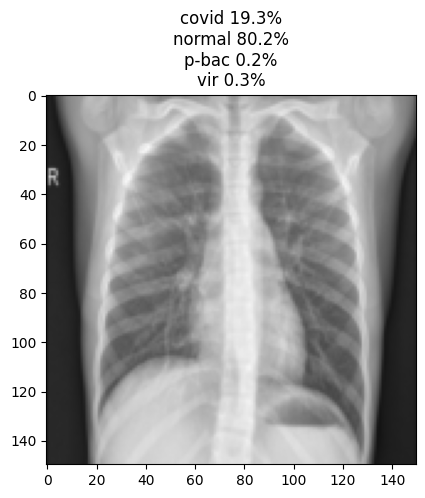

In [ ]:
# test single image
import cv2
import warnings
from skimage import transform

# prepare the image
img_r = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/covid_19/data_set/four_classes/test/normal/IM-0003-0001.jpeg')
img1 = np.array(img_r).astype('float32')/255
img2 = transform.resize(img1, (150, 150, 3))
img = np.expand_dims(img2, axis=0)

# prediction
r=main_model.predict(img)
labels = {'covid': 0 , 'normal':1 , 'p-bac':2, 'vir':3}
names= dict((v,k) for k,v in labels.items())
index = np.argmax(r)
name=names.get(index,"Unknown")

scores=r
# plot the result
plt.title(names[0] +" "+ str(round(scores[0][0]*100,1))+"%"+
          "\n"+names[1] +" "+ str(round(scores[0][1]*100,1))+"%"+
          "\n"+names[2] +" "+ str(round(scores[0][2]*100,1))+"%"+
          "\n"+names[3] +" "+ str(round(scores[0][3]*100,1))+"%")

plt.imshow(img2) 

# comparison the speed

In [ ]:
# prepare the test file used in testing the speed of my model
test_path = '/content/drive/MyDrive/Colab_Notebooks/covid_19/personal_model/personal_dataset/test'
test_batches = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    test_path, target_size=(150,150), batch_size=1, shuffle=False, seed=42, class_mode="categorical")

test_labels = test_batches.classes

import time
start_time = time.time()

predictions = main_model.predict(x=test_batches, steps=len(test_batches), verbose=0)

end_time = time.time()
runtime = end_time - start_time

cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
print('prediction runtime(main model):' , runtime)


Found 137 images belonging to 2 classes.
prediction runtime(main model): 20.537610054016113
